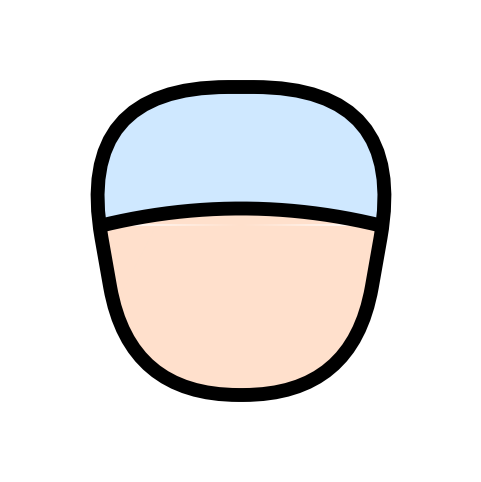

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.path import Path
from matplotlib.patches import PathPatch

# ----------------------------
# Face patch (rounded skewed rectangle)
# ----------------------------
def draw_face_patch(width, height, angle_top_to_bottom,
                    rounding_top, rounding_bottom,
                    cx=0.5, cy=0.5,
                    facecolor="none", edgecolor="black", lw=10,
                    zorder=20):
    theta = np.deg2rad(angle_top_to_bottom)
    dx = height * np.tan(theta)

    w_top = width
    w_bot = width + 2 * dx

    y_top = cy + height / 2
    y_bot = cy - height / 2

    tl = np.array([cx - w_top / 2, y_top])
    tr = np.array([cx + w_top / 2, y_top])
    br = np.array([cx + w_bot / 2, y_bot])
    bl = np.array([cx - w_bot / 2, y_bot])

    corners = [tl, tr, br, bl]  # clockwise

    r_corner = np.array([rounding_top, rounding_top, rounding_bottom, rounding_bottom], dtype=float)

    edge_len = [np.linalg.norm(corners[(i + 1) % 4] - corners[i]) for i in range(4)]
    for i in range(4):
        adj_min = min(edge_len[i - 1], edge_len[i])
        r_corner[i] = max(0.0, min(float(r_corner[i]), 0.49 * float(adj_min)))

    p_in, p_out = [], []
    for i in range(4):
        p = corners[i]
        p_prev = corners[i - 1]
        p_next = corners[(i + 1) % 4]
        r = float(r_corner[i])

        u_prev = (p_prev - p); u_prev /= np.linalg.norm(u_prev)
        u_next = (p_next - p); u_next /= np.linalg.norm(u_next)

        p_in.append(p + u_prev * r)
        p_out.append(p + u_next * r)

    verts, codes = [], []

    verts.append(tuple(p_out[0])); codes.append(Path.MOVETO)

    for i in [1, 2, 3]:
        verts.append(tuple(p_in[i]));     codes.append(Path.LINETO)
        verts.append(tuple(corners[i]));  codes.append(Path.CURVE3)
        verts.append(tuple(p_out[i]));    codes.append(Path.CURVE3)

    verts.append(tuple(p_in[0]));     codes.append(Path.LINETO)
    verts.append(tuple(corners[0]));  codes.append(Path.CURVE3)
    verts.append(tuple(p_out[0]));    codes.append(Path.CURVE3)

    verts.append((0.0, 0.0)); codes.append(Path.CLOSEPOLY)

    patch = PathPatch(
        Path(verts, codes),
        facecolor=facecolor,
        edgecolor=edgecolor,
        linewidth=lw,
        joinstyle="round",
        capstyle="round",
        zorder=zorder
    )
    return patch

# ----------------------------
# Robust px->data conversion (dy)
# ----------------------------
def _px_to_data_dy(ax, px):
    inv = ax.transData.inverted()
    x0, y0 = inv.transform((0.0, 0.0))
    x1, y1 = inv.transform((0.0, float(px)))
    return (y1 - y0)

# ----------------------------
# Get dense face boundary polygon in data coords
# ----------------------------
def _face_boundary_polygon(face_patch, interp=120):
    path_data = face_patch.get_path().transformed(face_patch.get_patch_transform())
    path_dense = path_data.interpolated(interp)
    polys = path_dense.to_polygons(closed_only=True)
    if not polys:
        raise ValueError("Could not extract polygon from face patch.")
    return max(polys, key=lambda a: a.shape[0])

# ----------------------------
# Build separator once (shared by fill + line)
# ----------------------------
def build_separator(ax, face_patch, cx=0.5, cy=0.5,
                    y_pos_px=15, curvature_px=35,
                    n=600, boundary_interp=200):
    ax.figure.canvas.draw()

    dy = _px_to_data_dy(ax, y_pos_px)
    dcurve = _px_to_data_dy(ax, curvature_px)
    y_sep = cy + dy

    poly = _face_boundary_polygon(face_patch, interp=boundary_interp)

    inter = []
    for i, ((x1, y1), (x2, y2)) in enumerate(zip(poly[:-1], poly[1:])):
        if (y1 <= y_sep <= y2) or (y2 <= y_sep <= y1):
            dyseg = (y2 - y1)
            if abs(dyseg) < 1e-12:
                continue
            t = (y_sep - y1) / dyseg
            if 0.0 <= t <= 1.0:
                x = x1 + t * (x2 - x1)
                inter.append({"x": float(x), "y": float(y_sep), "i": i, "t": float(t)})

    if len(inter) < 2:
        y_min = float(np.min(poly[:, 1])); y_max = float(np.max(poly[:, 1]))
        raise ValueError(
            f"Separator y={y_sep:.4f} did not intersect face. "
            f"Face y-range=[{y_min:.4f}, {y_max:.4f}]."
        )

    inter = sorted(inter, key=lambda d: d["x"])
    inter2 = [inter[0]]
    for d in inter[1:]:
        if abs(d["x"] - inter2[-1]["x"]) > 1e-6:
            inter2.append(d)
    if len(inter2) < 2:
        raise ValueError("Intersections collapsed after dedupe.")

    L, R = inter2[0], inter2[-1]

    p0 = np.array([L["x"], y_sep], dtype=float)
    p2 = np.array([R["x"], y_sep], dtype=float)
    pm = 0.5 * (p0 + p2)
    ctrl = np.array([pm[0], pm[1] + dcurve], dtype=float)

    t = np.linspace(0.0, 1.0, n)
    sep_pts = (1 - t)[:, None] ** 2 * p0 + 2 * (1 - t)[:, None] * t[:, None] * ctrl + t[:, None] ** 2 * p2

    return y_sep, sep_pts, L, R, poly

# ----------------------------
# Draw fills + separator line (single source of truth)
# ----------------------------
def draw_face_brain(ax, face_patch,
                    cx=0.5, cy=0.5,
                    # tweak knobs
                    y_pos_px=15,
                    curvature_px=35,
                    sep_n=600,
                    boundary_interp=200,
                    fill_pad_px=0,     # try 1-3 if you see any tiny bleed vs the line
                    lw=10,
                    brain_color="#cfe8ff",
                    face_color="#ffe0cc",
                    line_color="black",
                    z_fill=10,
                    z_line=30):

    y_sep, sep_pts, L, R, poly = build_separator(
        ax, face_patch, cx=cx, cy=cy,
        y_pos_px=y_pos_px, curvature_px=curvature_px,
        n=sep_n, boundary_interp=boundary_interp
    )

    pad_dy = _px_to_data_dy(ax, fill_pad_px) if fill_pad_px else 0.0
    if pad_dy != 0.0:
        sep_top = sep_pts.copy(); sep_top[:, 1] -= abs(pad_dy)  # top fill boundary down
        sep_bot = sep_pts.copy(); sep_bot[:, 1] += abs(pad_dy)  # bottom fill boundary up
    else:
        sep_top = sep_pts
        sep_bot = sep_pts

    def arc_points(A, B):
        iA, iB = A["i"], B["i"]
        pts = [np.array([A["x"], A["y"]], dtype=float)]
        j = iA + 1
        N = len(poly) - 1
        while True:
            pts.append(poly[j % N].astype(float))
            if (j % N) == (iB % N):
                break
            j += 1
        pts[-1] = np.array([B["x"], B["y"]], dtype=float)
        return np.vstack(pts)

    arc_LR = arc_points(L, R)
    arc_RL = arc_points(R, L)

    if np.mean(arc_LR[:, 1]) >= np.mean(arc_RL[:, 1]):
        top_arc, bot_arc = arc_LR, arc_RL
    else:
        top_arc, bot_arc = arc_RL, arc_LR

    top_poly = np.vstack([top_arc, sep_top[::-1, :]])
    bot_poly = np.vstack([sep_bot, bot_arc[::-1, :]])

    def poly_to_patch(pts, color, z):
        verts = [tuple(pts[0])]
        codes = [Path.MOVETO]
        for p in pts[1:]:
            verts.append(tuple(p))
            codes.append(Path.LINETO)
        verts.append((0.0, 0.0)); codes.append(Path.CLOSEPOLY)
        patch = PathPatch(Path(verts, codes), facecolor=color, edgecolor="none", zorder=z)
        patch.set_clip_path(face_patch)
        ax.add_patch(patch)
        return patch

    face_fill = poly_to_patch(bot_poly, face_color, z_fill)
    brain_fill = poly_to_patch(top_poly, brain_color, z_fill + 1)

    line = mlines.Line2D(sep_pts[:, 0], sep_pts[:, 1],
                         lw=lw, color=line_color,
                         solid_capstyle="round",
                         zorder=z_line)
    line.set_clip_path(face_patch)
    ax.add_line(line)

    return brain_fill, face_fill, line

# ----------------------------
# Single-cell runnable demo
# ----------------------------
if __name__ == "__main__":
    fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.1, 1.1)
    ax.set_aspect("equal")
    ax.axis("off")

    phi = (1 + 5**0.5) / 3

    height = 0.8
    width = height * phi
    lw_big = 10

    face_outline = draw_face_patch(
        width=width, height=height,
        angle_top_to_bottom=-10,
        rounding_top=0.5,
        rounding_bottom=0.3,
        cx=0.5, cy=0.5,
        facecolor="none",
        edgecolor="black",
        lw=lw_big,
        zorder=20
    )
    ax.add_patch(face_outline)

    # --- tweak these ---
    y_pos_px = 15
    curvature_px = 35
    fill_pad_px = 2   # set to 0 if you don't need it

    draw_face_brain(
        ax, face_outline,
        cx=0.5, cy=0.5,
        y_pos_px=y_pos_px,
        curvature_px=curvature_px,
        fill_pad_px=fill_pad_px,
        sep_n=700,
        boundary_interp=220,
        lw=lw_big,
        brain_color="#cfe8ff",
        face_color="#ffe0cc",
        line_color="black"
    )

    plt.show()
